# Tuần 4: Sử dụng dữ liệu thực tế

Chào mừng! Cho đến nay bạn chỉ làm việc với dữ liệu được tạo ra. Lần này bạn sẽ sử dụng tập dữ liệu [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) chứa dữ liệu về nhiệt độ tối thiểu hàng ngày được ghi lại ở Melbourne từ năm 1981 đến năm 1990. Ngoài việc sử dụng các lớp của Tensorflow để xử lý dữ liệu chuỗi như các lớp Tái diễn hoặc LSTM, bạn cũng sẽ sử dụng các lớp Convolutional để cải thiện hiệu suất của mô hình.

Bắt đầu nào!

_**LƯU Ý:** Để tránh lỗi từ hệ thống tự động chấm, bạn không được phép chỉnh sửa hoặc xóa một số ô trong sổ tay này. Vui lòng chỉ đặt giải pháp của bạn ở giữa nhận xét mã `### BẮT ĐẦU MÃ TẠI ĐÂY` và `### KẾT THÚC MÃ KẾT THÚC TẠI ĐÂY`, đồng thời không thêm bất kỳ ô mới nào. **Khi bạn đã vượt qua bài tập này** và muốn thử nghiệm với bất kỳ ô nào bị khóa, bạn có thể làm theo hướng dẫn ở cuối sổ ghi chép này._

In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

Bắt đầu bằng cách xem cấu trúc của csv chứa dữ liệu:

In [2]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



Như bạn có thể thấy, mỗi điểm dữ liệu bao gồm ngày và nhiệt độ tối thiểu được ghi lại cho ngày đó.


Trong bài tập đầu tiên, bạn sẽ viết mã một hàm để đọc dữ liệu từ csv nhưng bây giờ hãy chạy ô tiếp theo để tải hàm trợ giúp nhằm vẽ chuỗi thời gian.

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Phân tích dữ liệu thô
Bây giờ bạn cần đọc dữ liệu từ tệp csv. Để làm như vậy, hãy hoàn thành hàm `parse_data_from_file`.

Một vài điều cần lưu ý:

- Bạn nên bỏ dòng đầu tiên vì file chứa tiêu đề.
- Không cần lưu các điểm dữ liệu dưới dạng mảng nhiều mảng, danh sách thông thường là được.
- Để đọc từ tệp csv, hãy sử dụng `csv.reader` bằng cách chuyển các đối số thích hợp.
- `csv.reader` trả về một iterable trả về mỗi hàng trong mỗi lần lặp. Vì vậy, nhiệt độ có thể được truy cập thông qua row[1] và ngày có thể bị loại bỏ.
- Danh sách `thời gian` phải chứa mọi dấu thời gian (bắt đầu từ 0), đây chỉ là một dãy số có thứ tự có cùng độ dài với danh sách `nhiệt độ`.
- Các giá trị của `nhiệt độ` phải thuộc loại `float`. Bạn có thể sử dụng hàm `float` tích hợp của Python để đảm bảo điều này.

In [13]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
        ### START CODE HERE
        
        reader = csv.reader(csvfile, delimiter=',')
        
        next(reader)
        
        # Initialize a counter for timestamps
        timestamp = 0
        
        for row in reader:
            times.append(timestamp)
            temperatures.append(float(row[1]))
            timestamp += 1
            
        ### END CODE HERE
            
    return times, temperatures

Ô tiếp theo sẽ sử dụng hàm của bạn để tính toán `thời gian` và `nhiệt độ` và sẽ lưu chúng dưới dạng mảng có nhiều mảng trong lớp dữ liệu `G`. Ô này cũng sẽ vẽ chuỗi thời gian:

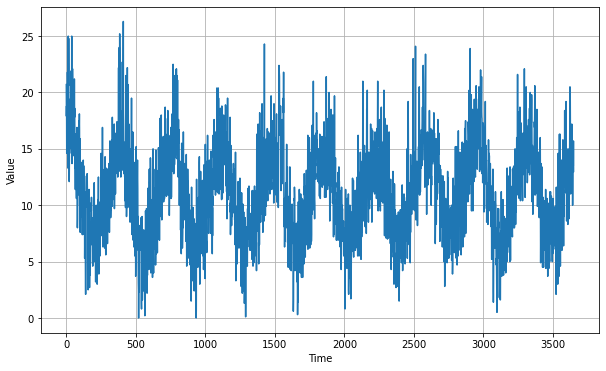

In [14]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

**Đầu ra dự kiến:**
<div>
<img src="images/temp-series.png" width="500"/>
</div>

## Xử lý dữ liệu

Vì bạn đã mã hóa các hàm `train_val_split` và `windowed_dataset` trong các bài tập của tuần trước nên lần này chúng được cung cấp cho bạn:

In [15]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [16]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Xác định kiến ​​trúc mô hình

Bây giờ bạn đã có một hàm sẽ xử lý dữ liệu trước khi dữ liệu được đưa vào mạng thần kinh để huấn luyện, đã đến lúc xác định kiến ​​trúc lớp của bạn. Giống như bài tập tuần trước, bạn sẽ thực hiện định nghĩa và biên dịch lớp theo hai bước riêng biệt. Bắt đầu bằng cách hoàn thành hàm `create_uncompiled_model` bên dưới.

Điều này được thực hiện để bạn có thể sử dụng lại các lớp của mô hình để điều chỉnh tốc độ học tập và đào tạo thực tế.

Gợi ý:

- Không cần phải có lớp `Lambda`.
- Sử dụng kết hợp các lớp `Conv1D` và `LSTM`, sau đó là các lớp `Dense`

In [19]:
def create_uncompiled_model():

    ### START CODE HERE
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[G.WINDOW_SIZE, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ]) 
    
    ### END CODE HERE

    return model

Bạn có thể kiểm tra mô hình của mình bằng mã bên dưới. Nếu bạn gặp lỗi thì có thể mô hình của bạn đang trả về một chuỗi. Bạn thực sự có thể sử dụng LSTM với `return_sequences=True` nhưng bạn phải đưa nó vào một lớp khác để tạo ra một dự đoán duy nhất. Bạn có thể xem lại các bài giảng hoặc các bài thí nghiệm chưa được chấm điểm trước đó để xem việc đó được thực hiện như thế nào.

In [20]:
# Test your uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):
    
    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)
    
# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

Testing model prediction with input of shape (32, 64)...
Your current architecture is compatible with the windowed dataset! :)


## Điều chỉnh tốc độ học - (Bài tập tùy chọn)

Như bạn đã thấy trong các bài giảng, bạn có thể tận dụng các lệnh gọi lại của Tensorflow để thay đổi linh hoạt tốc độ học trước khi thực hiện khóa đào tạo thực tế. Điều này có thể hữu ích trong việc tìm kiếm giá trị nào phù hợp nhất với mô hình của bạn. Lưu ý rằng đây chỉ là một cách để tìm ra tỷ lệ học tập tốt nhất. Có các kỹ thuật khác để tối ưu hóa siêu tham số nhưng nó nằm ngoài phạm vi của khóa học này.

Đối với trình tối ưu hóa, bạn có thể thử:

- tf.keras.optimizers.Adam
- tf.keras.optimizers.SGD với động lượng 0,9

In [21]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [22]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 9s 80ms/step - loss: 10.1551 - mae: 10.6541 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 6s 71ms/step - loss: 9.2780 - mae: 9.7761 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 5s 70ms/step - loss: 7.8895 - mae: 8.3867 - lr: 1.2589e-04
Epoch 4/100
77/77 [==============================] - 5s 65ms/step - loss: 4.3148 - mae: 4.7924 - lr: 1.4125e-04
Epoch 5/100
77/77 [==============================] - 5s 66ms/step - loss: 2.5011 - mae: 2.9644 - lr: 1.5849e-04
Epoch 6/100
77/77 [==============================] - 5s 68ms/step - loss: 2.2186 - mae: 2.6764 - lr: 1.7783e-04
Epoch 7/100
77/77 [==============================] - 5s 66ms/step - loss: 1.8658 - mae: 2.3186 - lr: 1.9953e-04
Epoch 8/100
77/77 [==============================] - 5s 64ms/step - loss: 1.8584 - mae: 2.3096 - lr: 2.2387e-04
Epoch 9/100
77/77 [==============================] - 5s 65ms/step - loss: 1.8853 - mae: 2.3412 - lr: 2

(0.0001, 10.0, 0.0, 10.0)

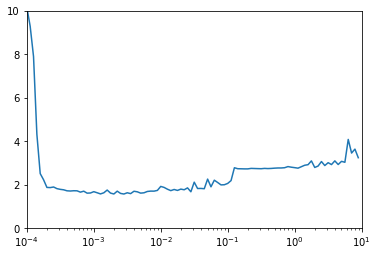

In [23]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

## Biên dịch mô hình
Bây giờ bạn đã huấn luyện mô hình trong khi thay đổi tốc độ học, đã đến lúc thực hiện huấn luyện thực tế sẽ được sử dụng để dự báo chuỗi thời gian. Để làm điều này, hãy hoàn thành hàm `create_model` bên dưới.

Lưu ý rằng bạn đang sử dụng lại kiến ​​trúc mà bạn đã xác định trong `create_uncompiled_model` trước đó. Bây giờ bạn chỉ cần biên dịch mô hình này bằng cách sử dụng mức mất, trình tối ưu hóa (và tốc độ học tập) thích hợp.

Gợi ý:

- Quá trình đào tạo phải thực sự nhanh chóng, vì vậy nếu bạn nhận thấy rằng mỗi kỷ nguyên mất hơn vài giây, hãy cân nhắc thử một kiến ​​trúc khác.


- Nếu sau kỷ nguyên đầu tiên bạn nhận được kết quả như thế này: loss: nan - mae: nan thì rất có thể mạng của bạn đang bị bùng nổ độ dốc. Đây là vấn đề thường gặp nếu bạn sử dụng SGD làm trình tối ưu hóa và đặt tốc độ học tập quá cao. Nếu bạn gặp phải vấn đề này, hãy cân nhắc việc giảm tốc độ học tập hoặc sử dụng Adam với tốc độ học tập mặc định.

In [24]:
def create_model():

    
    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
                  metrics=["mae"])  
    

    ### END CODE HERE

    return model

In [25]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 9s 82ms/step - loss: 4.4091 - mae: 4.8844
Epoch 2/50
77/77 [==============================] - 5s 70ms/step - loss: 2.0264 - mae: 2.4795
Epoch 3/50
77/77 [==============================] - 6s 71ms/step - loss: 1.8136 - mae: 2.2645
Epoch 4/50
77/77 [==============================] - 5s 67ms/step - loss: 1.7826 - mae: 2.2366
Epoch 5/50
77/77 [==============================] - 5s 67ms/step - loss: 1.7043 - mae: 2.1559
Epoch 6/50
77/77 [==============================] - 5s 68ms/step - loss: 1.6926 - mae: 2.1415
Epoch 7/50
77/77 [==============================] - 5s 68ms/step - loss: 1.6509 - mae: 2.0972
Epoch 8/50
77/77 [==============================] - 5s 67ms/step - loss: 1.6098 - mae: 2.0541
Epoch 9/50
77/77 [==============================] - 5s 65ms/step - loss: 1.5890 - mae: 2.0350
Epoch 10/50
77/77 [==============================] - 5s 64ms/step - loss: 1.5622 - mae: 2.0072
Epoch 11/50
77/77 [==============================] - 5s 64m

##Đánh giá dự báo

Bây giờ là lúc đánh giá hiệu quả của dự báo. Để làm điều này, bạn có thể sử dụng hàm `compute_metrics` mà bạn đã mã hóa trong bài tập trước:

In [26]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

Tại thời điểm này, chỉ có mô hình thực hiện dự báo đã sẵn sàng nhưng bạn vẫn cần tính toán dự báo thực tế.



## Dự báo mô hình nhanh hơn

Trong tuần trước, bạn đã thấy một cách tiếp cận nhanh hơn so với việc sử dụng vòng lặp for để tính toán dự báo cho từng điểm trong chuỗi. Hãy nhớ rằng cách tiếp cận nhanh hơn này sử dụng hàng loạt dữ liệu.

Mã để triển khai điều này được cung cấp trong `model_forecast` bên dưới. Lưu ý rằng mã này rất giống với mã trong hàm `windowed_dataset` với những điểm khác biệt:
- Tập dữ liệu được tạo cửa sổ bằng `window_size` thay vì `window_size + 1`
- Không nên sử dụng shuffle
- Không cần chia dữ liệu thành các tính năng và nhãn
- Một mô hình được sử dụng để dự đoán các lô của tập dữ liệu

In [27]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Bây giờ hãy tính toán dự báo thực tế:

**Lưu ý:** Không sửa đổi ô bên dưới.

Trình chấm điểm sử dụng cách cắt tương tự để nhận dự báo, vì vậy nếu bạn thay đổi ô bên dưới, bạn có nguy cơ gặp sự cố khi gửi mô hình của mình để chấm điểm.

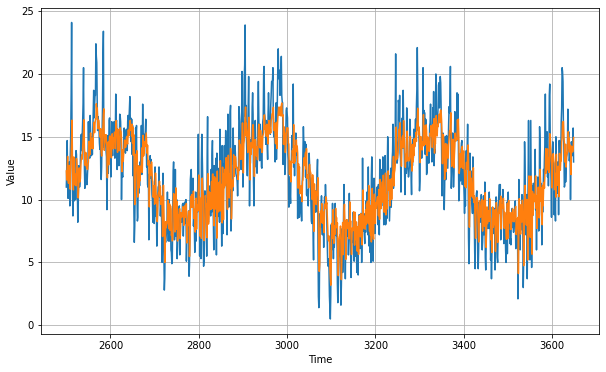

In [28]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [29]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.29, mae: 1.79 for forecast


**Để vượt qua nhiệm vụ này, dự báo của bạn phải đạt được MSE từ 6 trở xuống và MAE từ 2 trở xuống.**

- Nếu dự báo của bạn không đạt được ngưỡng này, hãy thử đào tạo lại mô hình của bạn với kiến ​​trúc khác (bạn sẽ cần chạy lại cả hai hàm `create_uncompiled_model` và `create_model`) hoặc điều chỉnh các tham số của trình tối ưu hóa.


- Nếu dự báo của bạn đã đạt được ngưỡng này, hãy chạy ô sau để lưu mô hình ở định dạng SavingModel sẽ được sử dụng để chấm điểm và sau khi làm như vậy, hãy gửi bài tập của bạn để chấm điểm.


- Môi trường này bao gồm một thư mục SavingModel giả chứa mô hình giả được huấn luyện cho một kỷ nguyên. **Để thay thế tệp này bằng mô hình thực tế của bạn, bạn cần chạy ô tiếp theo trước khi gửi để chấm điểm.**

In [30]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index
saved_model/my_model/saved_model.pb
saved_model/my_model/assets/


**Chúc mừng bạn đã hoàn thành bài tập tuần này!**

Bạn đã triển khai thành công mạng nơ-ron có khả năng dự báo chuỗi thời gian bằng cách tận dụng sự kết hợp các lớp của Tensorflow như Convolutional và LSTM! Điều này dẫn đến kết quả dự báo vượt qua tất cả những dự báo bạn đã thực hiện trước đó.

**Khi hoàn thành bài tập này, bạn đã hoàn thành chuyên môn! Hãy tạo cho mình một cái vỗ nhẹ vào lưng!!!**

<chi tiết>
<summary><font size="2" color="darkgreen"><b>Vui lòng nhấp vào đây nếu bạn muốn thử nghiệm bất kỳ mã nào không được phân loại.</b></font></summary>
<p><i><b>Lưu ý quan trọng: Vui lòng chỉ thực hiện việc này khi bạn đã vượt qua bài tập để tránh sự cố với hệ thống tự động chấm điểm.</b></i>
<ol>
<li> Trên menu của sổ ghi chép, hãy nhấp vào “Xem” > “Thanh công cụ di động” > “Chỉnh sửa siêu dữ liệu”</li>
<li> Nhấn nút “Chỉnh sửa siêu dữ liệu” bên cạnh ô mã mà bạn muốn khóa/mở khóa</li>
<li> Đặt giá trị thuộc tính cho “có thể chỉnh sửa” thành:
<ul>
<li> “đúng” nếu bạn muốn mở khóa </li>
<li> “false” nếu bạn muốn khóa nó </li>
</ul>
</li>
<li> Trên menu của sổ ghi chép, hãy nhấp vào “Xem” > “Thanh công cụ di động” > “Không có” </li>
</ol>
<p> Dưới đây là bản demo ngắn về cách thực hiện các bước trên:
<br>
<img src="https://drive.google.com/uc?export=view&id=14Xy_Mb17CZVgzVAgq7NCjMVBvSae3xO1"align="center">
</ chi tiết>